# Generation of synthetic time series (User Guide)

**ESSEC/CentraleSupélec**

## 0. Setup

### Import libraries

In [15]:
# Import libraries
from sdv.datasets.local import load_csvs
import os

import sys
sys.path.append('../src')

# Our module
from TimeSeriesGeneration.ts_generator import TSGenerator
from TimeSeriesGeneration.ts_similarity import TSSimilarityCheck
from TimeSeriesGeneration.data_processing import DataProcessor

### Load data and get metadata

In [21]:
# Load the data

# Get the absolute path of the current script file
current_dir = os.path.abspath('.')

# Navigate up from the current directory
parent_dir = os.path.dirname(current_dir)
# Define the path to the data folder relative to the grandparent directory
data_folder_path = os.path.join(parent_dir, "data")


datasets = load_csvs(folder_name=data_folder_path)

df = datasets["energy_dataset"]


In [22]:
# Create DataProcessor instance
data_processor = DataProcessor(df, obs_limit=1000, interpolate=True, drop_na_cols=True)
# The name of the time column is "time" in this dataframe and all columns can be used as identifiers in long format
# Get long dataframe and metadata
df_real = data_processor.convert_to_long_format(time_columns='time', verbose=True)
metadata = data_processor.get_metadata_long_df(identifier='variable', time_column='time', datetime_format='%Y-%m-%d %H:%M:%S')

                        time            variable  value
0  2015-01-01 00:00:00+01:00  generation biomass  447.0
1  2015-01-01 01:00:00+01:00  generation biomass  449.0
2  2015-01-01 02:00:00+01:00  generation biomass  448.0
3  2015-01-01 03:00:00+01:00  generation biomass  438.0
4  2015-01-01 04:00:00+01:00  generation biomass  428.0


## 1. Train PARSynthesizer on whole dataset and create samples

In [23]:
# Initialize Generator
ts_gen = TSGenerator(
    df=df_real,
    metadata=metadata,
    verbose=True
)

In [30]:
# Train model
ts_gen.train(n_epochs=100)

Epoch 100 | Loss -61.15801239013672: 100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


In [31]:
# Sample sequences
df_synth = ts_gen.sample(n_samples = 5)

100%|██████████| 5/5 [01:33<00:00, 18.65s/it]


## 2. Analyze similarity

In [32]:
# Create Similarity check
ts_sim = TSSimilarityCheck(df_real, df_synth, metadata)

In [33]:
# Get distance matrix if needed
distance_matrix = ts_sim.compute_distance_matrix()
distance_matrix

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
00000,588.039444,535.021912,712.053889,1077.799583,866.168250,621.419857,712.053889,712.053889,712.053889,NaN,...,645.470012,712.053889,1356.463047,403.972913,NaN,1349.773080,19460.564676,19343.598342,696.631823,689.992315
00001,641.246738,569.641569,789.637321,1084.111964,1004.213308,685.139779,789.637321,789.637321,789.637321,NaN,...,713.765453,789.637321,1642.399134,436.898127,NaN,1639.203265,19931.769918,20107.053985,770.947380,765.321901
0000a,636.787733,570.607308,786.489023,1046.186821,974.258819,678.436322,786.489023,786.489023,786.489023,NaN,...,707.788911,786.489023,1565.779168,426.636371,NaN,1562.454598,19399.261365,19569.369193,767.649329,761.957374
0000b,696.684747,633.702762,850.299582,1051.806595,925.360770,741.171135,850.299582,850.299582,850.299582,NaN,...,770.636935,850.299582,1525.633597,475.034951,NaN,1521.701479,16056.188955,16111.111073,830.560670,824.723120
0000c,633.441554,570.562186,785.409508,1071.991841,845.213971,673.951528,785.409508,785.409508,785.409508,NaN,...,707.761142,785.409508,1430.267608,450.021802,NaN,1424.885462,20091.782027,19985.312571,768.772523,759.650764


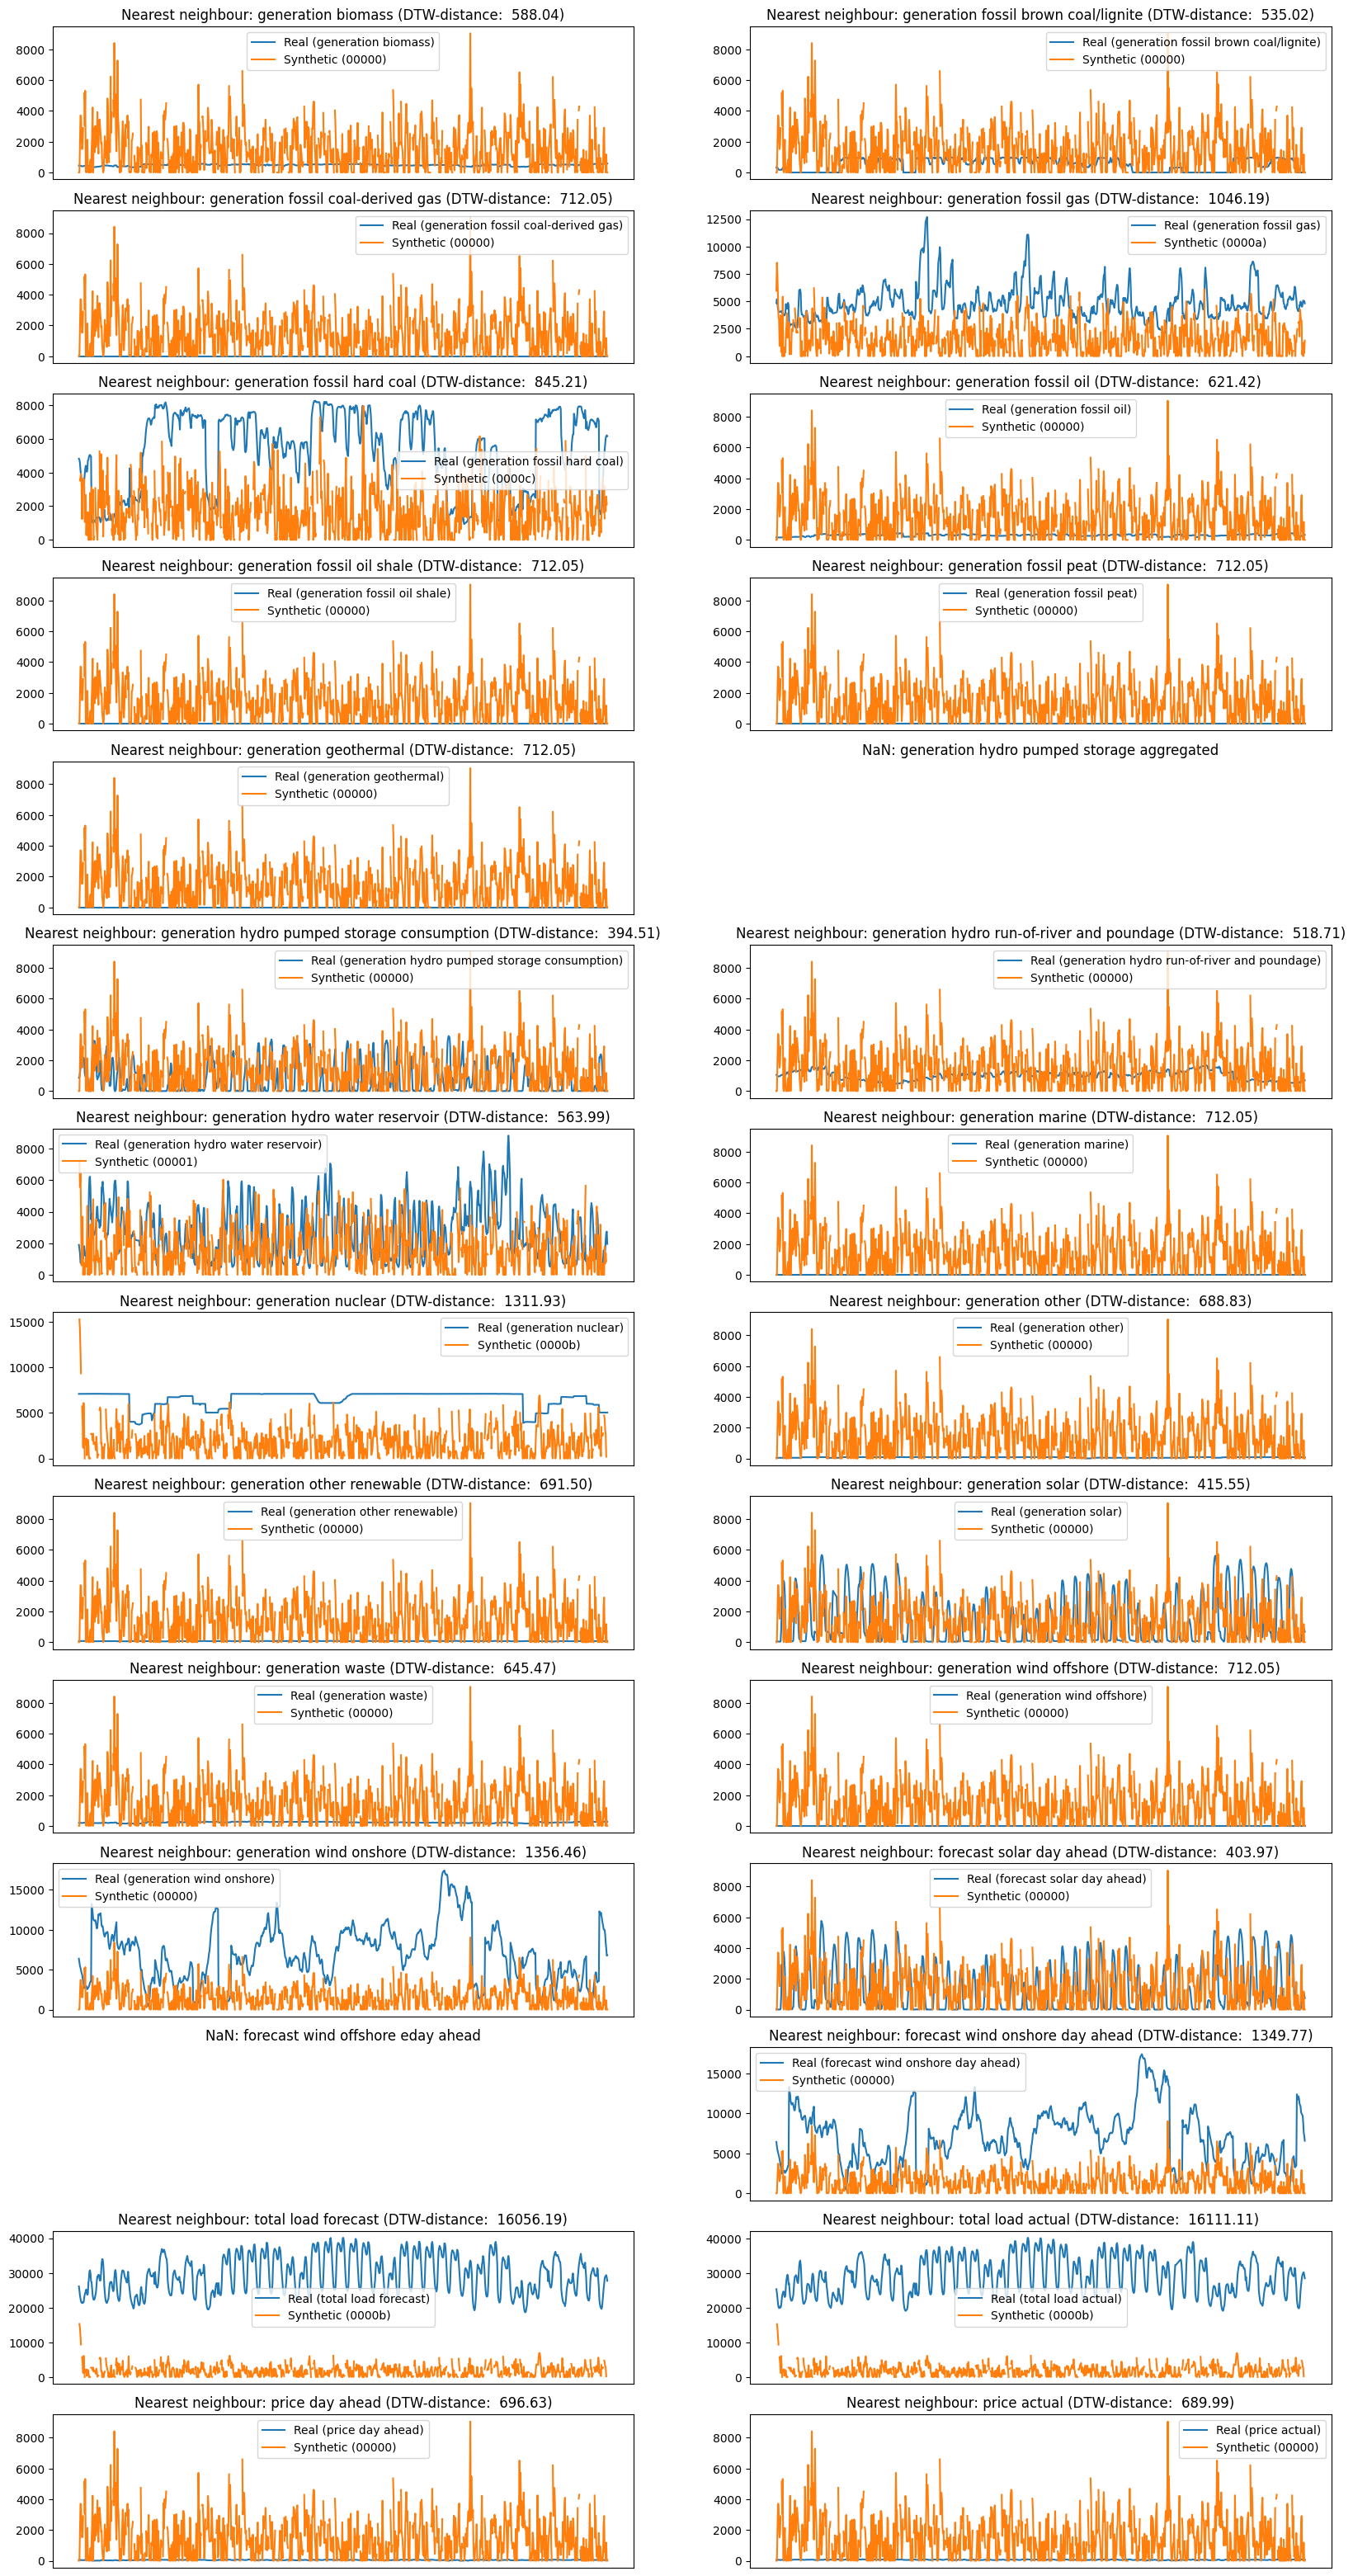

In [34]:
# For every real TS, plot its nearest neighbour
ts_sim.plot_nearest_neighbours(figsize = (20, 40))

## Tips for training

### Training on a single time series might help!

#### Training & Sampling

In [4]:
# Single out time series
df_wind_onshore = df_real[df_real["variable"] == "generation wind onshore"]

# Initialize Generator for generation wind onshore
ts_gen_wind = TSGenerator(
    df=df_wind_onshore,
    metadata=metadata,
    verbose=False
)

# Train model
ts_gen_wind.train(n_epochs=1000)

# Sample data
df_wind_onshore_synthetic = ts_gen_wind.sample(n_samples=5)

#### Evaluation

In [15]:
# Create Similarity check
ts_sim_wind = TSSimilarityCheck(df_wind_onshore, df_wind_onshore_synthetic, metadata)

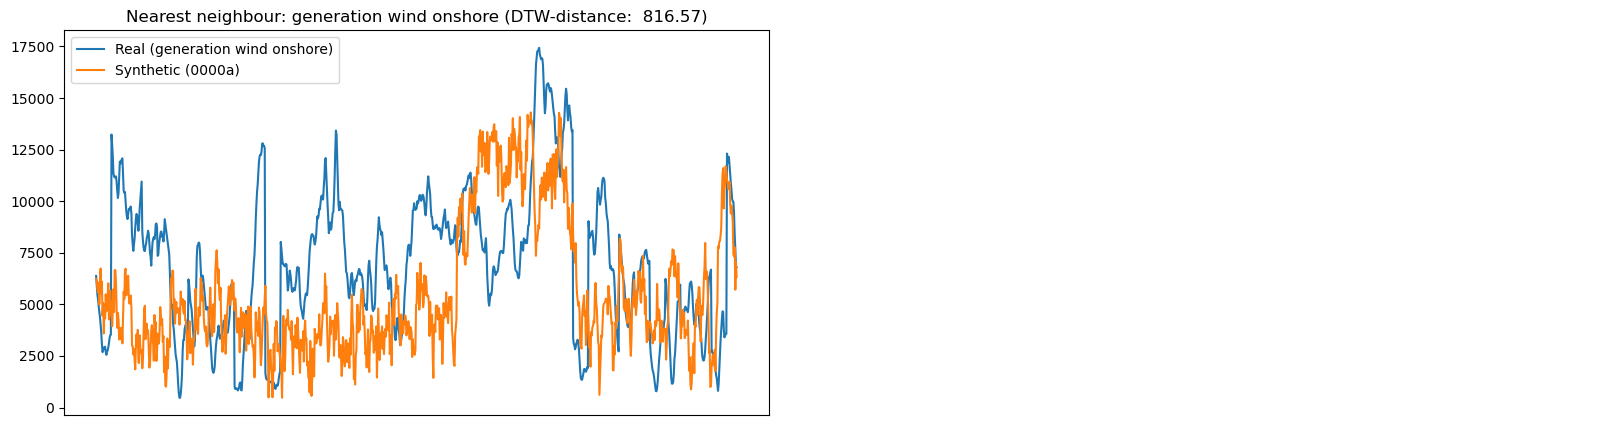

In [16]:
# Plot its nearest neighbour
ts_sim_wind.plot_nearest_neighbours(figsize = (20, 5))

**Comment:** Due to the model training on a single time series, it is better able to capture the specifities and reduce the distance between the real and the synthetic time series. However, the model would probably benefit from training on multiple *similar* time series.